In [24]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
F32_MIN = np.float32(-3.4028235e+38).item()  # ~ -3.40282306e+38 in your files
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass
import csv
from copy import deepcopy
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch


In [25]:
import os
import re
import numpy as np
from datetime import datetime
from torch.utils.data import Dataset
import rasterio
import pandas as pd
import torch
import matplotlib.pyplot as plt


In [144]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm
import csv
from src.models import PConvUNet2D
from src.data import TempoPandoraInpaintDataset, Normalizer, load_classification_pickle
from src.losses import calculate_metrics, warmup_loss
from src.utils import visualize_batch, _add_shape,load_shapefile_segments_pyshp, generate_realistic_gaps_simple


complete, partial, blank = load_classification_pickle(input_file='/work/srs108/pconv2d/file_classification_nop.pkl')
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'
z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)
normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/hpc/home/srs108/TEMPO/cus/cb_2018_us_state_500k.shp"

pandora_df = pd.read_csv("/hpc/home/srs108/TEMPO/pandora_filtered_data.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")



# train_ds.sample_vis(train=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
def _wrap_lon_180(lons):
    """Normalize longitudes to [-180, 180]."""
    arr = np.asarray(lons, dtype=float)
    m = np.isfinite(arr)
    arr[m] = ((arr[m] + 180.0) % 360.0) - 180.0
    return arr
def _lonlat_to_rowcol_vec(lons, lats, transform, raster_crs):

    lons = np.asarray(lons, dtype=float)
    lats = np.asarray(lats, dtype=float)
    # mask invalid inputs
    good = np.isfinite(lons) & np.isfinite(lats)
    rows = np.full_like(lons, fill_value=np.nan, dtype=float)
    cols = np.full_like(lons, fill_value=np.nan, dtype=float)

    if not good.any(): return np.array([], dtype=np.int32), np.array([], dtype=np.int32)

    try:
        from pyproj import CRS, Transformer
        src = CRS.from_epsg(4326)  # Pandora files give lon/lat in WGS84
        dst = raster_crs if raster_crs is not None else CRS.from_epsg(4326)
        if not isinstance(dst, CRS):
            dst = CRS.from_user_input(dst)
        xf = Transformer.from_crs(src, dst, always_xy=True)
        xs, ys = xf.transform(lons[good], lats[good])
    except Exception:
        # Fallback: assume raster is already in lon/lat
        xs, ys = lons[good], lats[good]

    # Affine inverse: xy -> col,row
    inv = ~transform
    cc = []; rr = []
    for x, y in zip(xs, ys):
        c, r = inv * (x, y)
        cc.append(c); rr.append(r)
    cols[good] = np.round(cc)
    rows[good] = np.round(rr)

    # keep only valid converted points
    rows_i = rows[good].astype(np.int32)
    cols_i = cols[good].astype(np.int32)
    return rows_i, cols_i


def _rowcol_to_xy_vec(rows, cols, transform):
    """
    Vectorized: pixel row/col -> raster xy using the affine transform.
    """
    rows = np.asarray(rows, dtype=float)
    cols = np.asarray(cols, dtype=float)
    xs, ys = [], []
    for r, c in zip(rows, cols):
        x, y = transform * (c, r)
        xs.append(x); ys.append(y)
    return np.asarray(xs), np.asarray(ys)


In [145]:
class TempoPandoraInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None,
                pandora_csv=None,
                time_tolerance="30min"):
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        # store and index files by timestamp
        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)

        # sort by time (keep a parallel array of paths)
        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]
        
        # --------- Pandora table ----------
        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            if isinstance(pandora_csv, pd.DataFrame):
                df = pandora_csv.copy()
            else:
                df = pd.read_csv(pandora_csv)

            req = {"datetime","NO2"}
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df

    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- time parsing ----------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT
            
    def sample_vis(self, idx=None, train=None, shp_path='/work/srs108/pconv2d/cus/cb_2018_us_state_500k.shp"', seed=42):
        if idx is None:
            idx = np.random.randint(len(self))

        # Use the dataset's train flag if not explicitly provided
        if train is None:
            train = self.train

        sample = self[idx]

        inp_np = sample["masked_img"][0].numpy()
        known_mask = sample["known_mask"][0].numpy().astype(bool)
        targ = sample['target'][0].numpy()

        # Get Pandora data if available
        p_mask = sample.get('p_mask', None)
        p_val_map = sample.get('p_val_map', None)

        # Calculate vmin/vmax for consistent scaling
        vmin, vmax = np.percentile(targ[np.isfinite(targ)], [2, 98])
        cmap_v = plt.cm.viridis.copy()
        cmap_v.set_bad("white")

        # Get image metadata for Pandora plotting
        path = sample["path"]
        date_str = path.split('/')[-1].split('.')[0]
        date = datetime.strptime(date_str, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

        # Get georeferencing info for Pandora
        with rasterio.open(path) as src:
            tr = src.transform
            crs = src.crs
            H, W = src.height, src.width

        ts = self._parse_time_from_fname(os.path.basename(path))
        xmin, ymin, xmax, ymax = array_bounds(H, W, tr)

        # Load shapefile segments if provided
        segments = []
        if shp_path:
            segments = load_shapefile_segments_pyshp(shp_path, crs)

        def _add_shape_and_pandora(ax, plot_pandora=True):
            """Helper function to add shapefile and Pandora stations"""
            # Add shapefile
            if segments:
                ax.add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))

            # Add Pandora stations if available and requested
            if plot_pandora and hasattr(self, 'pandora_df') and self.pandora_df is not None and ts is not pd.NaT:
                # Filter Pandora data for this timestamp
                dfw = self.pandora_df[
                    (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                    (self.pandora_df["datetime"] <= ts + self.time_tolerance)
                ].copy()

                if not dfw.empty:
                    if "station" in dfw.columns:
                        dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                        dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

                    # Create color map for stations
                    stations_all = self.pandora_df["station"].unique()
                    color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))

                    # Get coordinates
                    lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
                    lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
                    ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats >= -90) & (lats <= 90)

                    if ok_ll.sum() > 0:
                        dfw = dfw.loc[ok_ll].copy()
                        rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
                        labels = dfw["station"].astype(str).to_numpy()

                        rr_i = rr.astype(int)
                        cc_i = cc.astype(int)
                        ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
                        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

                        if rr_i.size > 0:
                            xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

                            for x, y, lab in zip(xs, ys, labels):
                                c = color_map.get(lab, "red")

                                # Plot with white halo + colored marker + black edge
                                ax.scatter(x, y, s=110, marker='D', color='white', zorder=4, linewidths=0)
                                sc = ax.scatter(x, y, s=80, marker='D', color=c, edgecolor='k', linewidth=0.8, zorder=5)
                                sc.set_path_effects([pe.Stroke(linewidth=1.4, foreground='white'), pe.Normal()])

                            return True, color_map, labels  # Return info for legend

            return False, {}, []

        if train:
            # For training dataset, we have the realistic gaps
            realistic_gaps = sample['fake_mask'][0].numpy().astype(bool)
            all_masks = sample["known_and_fake_mask"][0].numpy().astype(bool)

            # SEPARATE THE GAPS: Extract only the gap pixels (not the original missing data)
            gaps_only_mask = known_mask & (~realistic_gaps)  # Areas that are known but made into gaps

            # Print statistics
            original_missing = (~known_mask).sum()
            gaps_only = gaps_only_mask.sum()
            all_artificial = (~realistic_gaps).sum()
            total_holes = (~all_masks).sum()
            gap_percentage = 100 * gaps_only / known_mask.sum()

            fig, ax = plt.subplots(1, 4, figsize=(26, 6))

            # Panel 1: Input (masked with all masks) + Pandora
            im0 = ax[0].imshow(np.ma.array(inp_np, mask=~all_masks), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[0].set_title(f"Input (all masks)\n{date}")
            ax[0].set_xlim(xmin, xmax)
            ax[0].set_ylim(ymin, ymax)
            ax[0].set_aspect('equal')
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 1
            has_pandora, color_map, station_labels = _add_shape_and_pandora(ax[0], plot_pandora=True)

#             # Panel 2: Original missing data (sensor holes)
#             ax[1].imshow(known_mask == 0, cmap="Reds", alpha=0.7)
#             ax[1].set_title("Original Missing Data")

            # Panel 3: GAPS ONLY (artificial holes in previously known areas)
            ax[1].imshow(gaps_only_mask, cmap="Blues", alpha=0.7)
            ax[1].set_title(f"Gaps Only {gap_percentage:.1f}%")

            # Panel 4: Combined mask (all holes)
            ax[2].imshow(all_masks == 0, cmap="gray", alpha=0.7)
            ax[2].set_title("All Masks Combined")

            # Panel 5: Original target + Pandora
            im4 = ax[3].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[3].set_title(f"Original Target\n{date}")
            ax[3].set_xlim(xmin, xmax)
            ax[3].set_ylim(ymin, ymax)
            ax[3].set_aspect('equal')
            fig.colorbar(im4, ax=ax[3], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 5
            _add_shape_and_pandora(ax[3], plot_pandora=True)

            # Add legend if Pandora stations were plotted
            if has_pandora and len(station_labels) > 0:
                legend_handles = []
                for lab in np.unique(station_labels):
                    c = color_map.get(lab, "red")
                    proxy = Line2D([0], [0], marker='D', color='none',
                                 markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
                                 markersize=9, label=lab)
                    legend_handles.append(proxy)

                ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.85, 1),
                            loc="upper left", borderaxespad=0., frameon=True,
                            fontsize=10, markerscale=1.2)

            for a in ax[1:4]:  # Skip panels with geographic coords
                a.axis("off")

            plt.tight_layout()
            plt.show()

        else:
            # Validation dataset: show only 3 panels (no artificial gaps)
            fig, ax = plt.subplots(1, 3, figsize=(18, 6))

            # Panel 1: Input (masked with known mask only) + Pandora
            im0 = ax[0].imshow(np.ma.array(inp_np, mask=~known_mask), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[0].set_title(f"Input (original mask)\n{date}")
            ax[0].set_xlim(xmin, xmax)
            ax[0].set_ylim(ymin, ymax)
            ax[0].set_aspect('equal')
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 1
            has_pandora, color_map, station_labels = _add_shape_and_pandora(ax[0], plot_pandora=True)

            # Panel 2: Original missing data
            ax[1].imshow(known_mask == 0, cmap="Reds", alpha=0.7)
            ax[1].set_title("Original Missing Data")

            # Panel 3: Original target + Pandora
            im2 = ax[2].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[2].set_title(f"Original Target\n{date}")
            ax[2].set_xlim(xmin, xmax)
            ax[2].set_ylim(ymin, ymax)
            ax[2].set_aspect('equal')
            fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 3
            _add_shape_and_pandora(ax[2], plot_pandora=True)

            # Add legend if Pandora stations were plotted
            if has_pandora and len(station_labels) > 0:
                legend_handles = []
                for lab in np.unique(station_labels):
                    c = color_map.get(lab, "red")
                    proxy = Line2D([0], [0], marker='D', color='none',
                                 markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
                                 markersize=9, label=lab)
                    legend_handles.append(proxy)

                ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.85, 1),
                            loc="upper left", borderaxespad=0., frameon=True,
                            fontsize=10, markerscale=1.2)

            ax[1].axis("off")  # Only turn off axis for the middle panel

            plt.tight_layout()
            plt.show()
        
    # ---------- torch Dataset API ----------
    def __len__(self): return len(self.files)

    def __getitem__(self, idx):     
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img) 
        
        # ---------- Pandora anchors ----------
        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        xy_list, val_list = [], []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                (self.pandora_df["datetime"] <= ts + self.time_tolerance)
            ].copy()

            if not dfw.empty:
                # per-station nearest in time (if station column exists)
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = dfw.sort_values(["station","abs_dt"]).groupby("station", as_index=False).first()
                    
                # get row/col (prefer provided; else compute from lat/lon)
                if ("row" in dfw.columns) and ("col" in dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                else:
                    # compute using geotransform from this raster
                    with rasterio.open(path) as src:
                        tr = src.transform
                    if not {"lat","lon"}.issubset(set(dfw.columns)):
                        rows, cols = np.array([], dtype=int), np.array([], dtype=int)
                    else:
                        xs = dfw["lon"].to_numpy()
                        ys = dfw["lat"].to_numpy()
                        # invert: lon,lat -> row,col
                        rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                        cols = np.array([int(round(c)) for c, r in rc])
                        rows = np.array([int(round(r)) for c, r in rc])

                # keep anchors inside image
                ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                rows, cols = rows[ok], cols[ok]
                vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

                # optional normalization for Pandora values
                if hasattr(self.normalizer, "normalize_pandora_array"): vals_n = self.normalizer.normalize_pandora_array(vals.astype(np.float64)).astype(np.float32)
                elif hasattr(self.normalizer, "normalize_pandora"): vals_n = np.array([self.normalizer.normalize_pandora(v) for v in vals], dtype=np.float32)
                else: vals_n = vals.astype(np.float32)  # identity

                for r, c, v_n in zip(rows, cols, vals_n):
                    pandora_mask[r, c] = 1.0
                    pandora_val_map[r, c] = v_n
                    xy_list.append((int(r), int(c)))
                val_list = vals_n.tolist()
                
        if self.train:
            n_blobs= np.random.randint(0,5)
            realistic_gaps = generate_realistic_gaps_simple(
                                    shape=(H, W), 
                                    tempo_mask=(known_mask),  # Your TEMPO valid pixel mask
                                    n_blobs=n_blobs, 
                                    blob_size_range=(20, 74),  # Can make even larger
                                    threshold=0.6
                                )

            all_masks = known_mask * realistic_gaps
            img_with_holes = img_n * all_masks
                        

            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),         #input image to model with all holes real and / or fake
                "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),       # mask used in training, 
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            # real missing pixels only, 1=pixel available, 0=no pixel available
                "fake_mask": torch.from_numpy(realistic_gaps).unsqueeze(0).float(),          # salt/pepper holes
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
                "path": path,
            }
            return sample

        else:
            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "masked_img": torch.from_numpy(img_n).unsqueeze(0).float(),         #input image to model with all holes real and / or fake
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            # real missing pixels only, 1=pixel available, 0=no pixel available
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
                "path": path}
        
            return sample

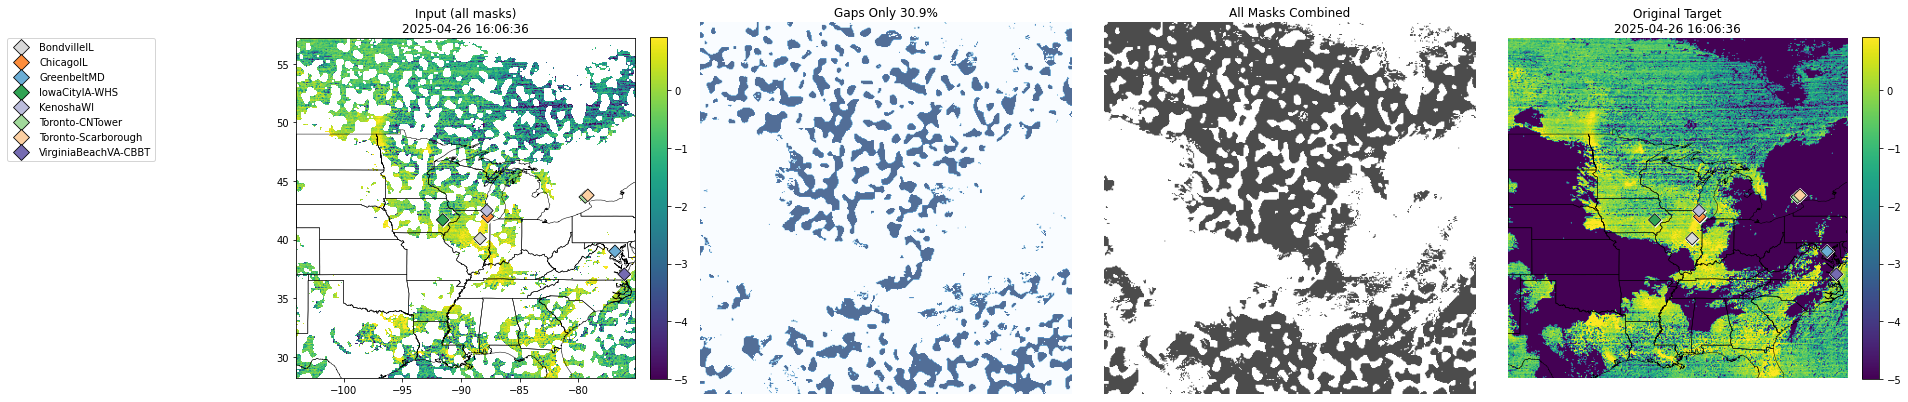

In [140]:
train_ds = TempoInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)

train_ds.sample_vis()

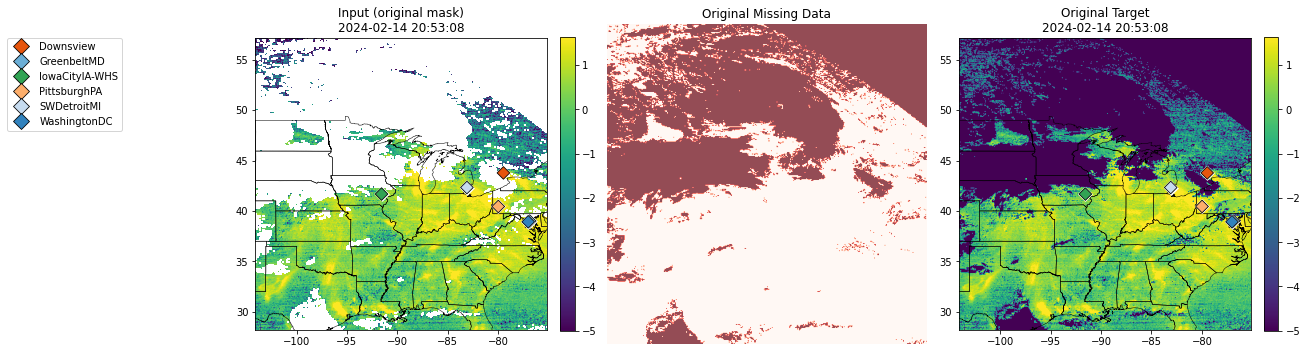

In [138]:
val_ds = TempoInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files, pandora_csv=pandora_df)
val_ds.sample_vis(train=False)

In [146]:
train_ds = TempoInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
val_ds = TempoInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

In [158]:
def _add_shape_pixel(ax, segments, tr, alpha=0.8, color="k"):
    """Add shapefile to pixel-coordinate panels"""
    if segments:
        segments_pixel = []
        for seg in segments:
            if len(seg) > 0:
                pixel_coords = []
                for x_geo, y_geo in seg:
                    col, row = ~tr * (x_geo, y_geo)
                    pixel_coords.append([col, row])
                segments_pixel.append(np.array(pixel_coords))
        ax.add_collection(LineCollection(segments_pixel, colors=color, linewidths=0.6, zorder=6, alpha=alpha))
        
def visualize_batch(epoch, model, normalizer, dataloader, batch_idx=0, sample_idx=0, device="cuda", save=False, train=True, shp_path=None, avg_thr=0.2):
    """
    Visualize model predictions from a DataLoader following the dataset's pandora setup
    """
    model.eval()
    
    # Get a batch from the dataloader
    try:
        for i, batch in enumerate(dataloader):
            if i == batch_idx:
                break
        else:
            print(f"Batch index {batch_idx} not found in dataloader")
            return
    except Exception as e:
        print(f"Error getting batch from dataloader: {e}")
        return
    
    # Extract the specific sample from the batch
    batch_size = batch["masked_img"].shape[0]
    if sample_idx >= batch_size:
        print(f"Sample index {sample_idx} not available in batch of size {batch_size}")
        sample_idx = 0
        print(f"Using sample index {sample_idx} instead")
    
    # Create sample dict by extracting the specific index from each tensor
    sample = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            sample[key] = value[sample_idx]
        elif isinstance(value, (list, tuple)):
            sample[key] = value[sample_idx]
        else:
            sample[key] = value

    # Get Pandora data from sample
    p_mask = sample.get('p_mask', torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
    p_val_map = sample.get('p_val_mask', torch.zeros_like(sample["known_mask"])).numpy()
    
    # Get common data
    img = sample["masked_img"].unsqueeze(0).to(device)
    mask_obs = sample["known_mask"].unsqueeze(0).to(device)
    target = sample["target"].unsqueeze(0).to(device)
    
    # For training, get additional masks
    if train:
        mask = sample["known_and_fake_mask"].unsqueeze(0).to(device)
        fake_mask = sample['fake_mask'].unsqueeze(0).to(device)
        fake_mask_np = fake_mask[0,0].cpu().numpy().astype(bool)
    else:
        mask = mask_obs
    
    # Get model prediction
    with torch.no_grad():
        pred, out_mask = model(img, mask)
    
    # Convert to numpy
    inp_np = normalizer.denormalize_image(img[0,0].cpu().numpy())
    mask_obs_np = mask_obs[0,0].cpu().numpy().astype(bool)
    pred_np = normalizer.denormalize_image(pred[0,0].cpu().numpy())
    tgt_np = normalizer.denormalize_image(target[0,0].cpu().numpy())
    
    if train:
        mask_np = sample["known_and_fake_mask"][0].cpu().numpy().astype(bool)
    else:
        mask_np = mask_obs_np

    # Extract metadata - FOLLOWING DATASET APPROACH
    path = sample["path"]
    date = path.split('/')[-1].split('.')[0]
    date = datetime.strptime(date, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

    # Get georeferencing info - FOLLOWING DATASET APPROACH
    with rasterio.open(path) as src:
        tr = src.transform
        crs = src.crs
        H, W = src.height, src.width
    
    xmin, ymin, xmax, ymax = array_bounds(H, W, tr)

    # Load shapefile segments - FOLLOWING DATASET APPROACH
    segments = []
    if shp_path:
        try:
            segments = load_shapefile_segments_pyshp(shp_path, crs)
        except Exception as e:
            print(f"Warning: Could not load shapefile: {e}")

    # Calculate Pandora vs Prediction RMSE
    pandora_rmse = None
    pandora_rho = None
    n_pandora_stations = 0
    
    if p_mask.any():
        pandora_rows, pandora_cols = np.where(p_mask)
        if len(pandora_rows) > 0:
            pandora_values = p_val_map[pandora_rows, pandora_cols]
            
            # Denormalize Pandora values if possible
            if hasattr(normalizer, 'denormalize_pandora'):
                pandora_values_denorm = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])
            elif hasattr(normalizer, 'denormalize_pandora_array'):
                pandora_values_denorm = normalizer.denormalize_pandora_array(pandora_values)
            else:
                pandora_values_denorm = pandora_values
            
            pred_at_pandora = pred_np[pandora_rows, pandora_cols]
            
            valid_mask = np.isfinite(pandora_values_denorm) & np.isfinite(pred_at_pandora)
            if valid_mask.sum() > 0:
                pandora_valid = pandora_values_denorm[valid_mask]
                pred_valid = pred_at_pandora[valid_mask]
                
                pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid)**2))
                if len(pandora_valid) > 1:
                    from scipy import stats
                    pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                n_pandora_stations = len(pandora_valid)

    # Calculate performance metrics
    holes_total = (~mask_np).sum()
    holes_filled_valid = ((~mask_np) & np.isfinite(pred_np)).sum()
    fill_percentage = 100.0 * holes_filled_valid / max(holes_total, 1)

    # Set up colormap and scaling - FOLLOWING DATASET APPROACH
    finite_vals = tgt_np[np.isfinite(tgt_np)]
    if finite_vals.size:
        vmin, vmax = np.percentile(finite_vals, [2, 98])
        if not np.isfinite(vmin) or not np.isfinite(vmax) or (vmin == vmax):
            vmin, vmax = finite_vals.min(), finite_vals.max()
    else:
        vmin, vmax = 0.0, 1.0
    
    cmap_v = plt.cm.viridis.copy()
    cmap_v.set_bad(color="white")
    
    # PANDORA STATION PLOTTING - FOLLOWING DATASET APPROACH EXACTLY
    def add_pandora_stations(ax, add_legend=False):
        """Add Pandora stations using the same approach as dataset preview_with_pandora"""
        legend_handles = []
        
        if p_mask.any():
            pandora_rows, pandora_cols = np.where(p_mask)
            
            if len(pandora_rows) > 0:
                # Get Pandora values (denormalized)
                pandora_values = p_val_map[pandora_rows, pandora_cols]
                if hasattr(normalizer, 'denormalize_pandora'):
                    pandora_values_denorm = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])
                elif hasattr(normalizer, 'denormalize_pandora_array'):
                    pandora_values_denorm = normalizer.denormalize_pandora_array(pandora_values)
                else:
                    pandora_values_denorm = pandora_values
                
                # Convert row/col to x/y using transform - FOLLOWING DATASET APPROACH
                xs, ys = _rowcol_to_xy_vec(pandora_rows, pandora_cols, tr)
                
                # Create color scheme - simplified version for visualization
                colors = cm.tab20c(np.linspace(0, 1, len(pandora_rows)))
                
                for i, (x, y, val) in enumerate(zip(xs, ys, pandora_values_denorm)):
                    c = colors[i] if len(colors) > 1 else 'red'
                    
                    # Plot with white halo + black edge - FOLLOWING DATASET APPROACH
                    ax.scatter(x, y, s=110, marker='D', color='white', zorder=4, linewidths=0)
                    sc = ax.scatter(x, y, s=80, marker='D', color=c, edgecolor='k', linewidth=0.8, zorder=5)
                    
                    # Add path effects for visibility - FOLLOWING DATASET APPROACH
                    sc.set_path_effects([pe.Stroke(linewidth=1.4, foreground='white'), pe.Normal()])
                    
                    if add_legend:
                        # Create legend proxy
                        proxy = Line2D([0], [0], marker='D', color='none',
                                     markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
                                     markersize=9, label=f"Station_{i+1}")
                        legend_handles.append(proxy)
        
        return legend_handles

    if train:
        sample_type = "Training"
        
        # Calculate gap statistics and RMSE for training
        known_mask_np = mask_obs_np
        current_mask_np = mask_np
        artificial_holes = known_mask_np & (~current_mask_np)
        gap_percentage = 100.0 * artificial_holes.sum() / max(known_mask_np.sum(), 1)
        
        # Calculate RMSE for artificial holes
        reconstruction_title = "Reconstruction"
        if artificial_holes.sum() > 0:
            pred_in_artificial = pred_np[artificial_holes]
            target_in_artificial = tgt_np[artificial_holes]

            valid_mask = np.isfinite(pred_in_artificial) & np.isfinite(target_in_artificial)
            if valid_mask.sum() > 0:
                pred_valid = pred_in_artificial[valid_mask]
                target_valid = target_in_artificial[valid_mask]

                rmse = np.sqrt(np.mean((pred_valid - target_valid)**2))
                from scipy import stats
                rho, _ = stats.spearmanr(pred_valid, target_valid)
                
                reconstruction_title = f"Reconstruction\nRMSE: {rmse:.4E} | ρ: {rho:.2f}"
        
        fig, ax = plt.subplots(1, 5, figsize=(25, 6))
        
        # Panel 0: Input - USING RIO_SHOW APPROACH
        disp_inp = np.ma.masked_invalid(np.ma.array(inp_np, mask=~mask_np))
        im0 = rio_show(disp_inp, transform=tr, ax=ax[0], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
        ax[0].set_aspect('equal', adjustable='box')
        ax[0].margins(0); ax[0].autoscale(False)
        ax[0].set_title(f"Input (N/A = white)\n{date}")
        if segments:
            ax[0].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        legend_handles = add_pandora_stations(ax[0], add_legend=True)
        cbar0 = fig.colorbar(im0.get_images()[0], ax=ax[0], fraction=0.046, pad=0.04)
        cbar0.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")

        # Panel 1: Artificial holes
        ax[1].imshow(~artificial_holes, cmap="Reds", alpha=0.8)
        ax[1].set_title(f"Artificial Holes ({gap_percentage:.1f}%)")
        _add_shape_pixel(ax[1], segments, tr)
        
        # Panel 2: Reconstruction - USING RIO_SHOW APPROACH
        disp_pred = np.ma.masked_invalid(pred_np)
        im2 = rio_show(disp_pred, transform=tr, ax=ax[2], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[2].set_xlim(xmin, xmax); ax[2].set_ylim(ymin, ymax)
        ax[2].set_aspect('equal', adjustable='box')
        ax[2].margins(0); ax[2].autoscale(False)
        ax[2].set_title(reconstruction_title)
        if segments:
            ax[2].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        add_pandora_stations(ax[2])
        cbar2 = fig.colorbar(im2.get_images()[0], ax=ax[2], fraction=0.046, pad=0.04)
        cbar2.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")

        # Panel 3: Filled values
        filled_only = np.full_like(pred_np, np.nan, dtype=np.float32)
        filled_only[~mask_np] = pred_np[~mask_np]
        ax[3].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[3].set_title("Filled Values in Holes")
        fig.colorbar(ax[3].images[0], ax=ax[3], fraction=0.046, pad=0.04)
        _add_shape_pixel(ax[3], segments, tr)

        # Panel 4: Target - USING RIO_SHOW APPROACH
        disp_tgt = np.ma.masked_invalid(np.ma.array(tgt_np, mask=~mask_obs_np))
        im4 = rio_show(disp_tgt, transform=tr, ax=ax[4], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[4].set_xlim(xmin, xmax); ax[4].set_ylim(ymin, ymax)
        ax[4].set_aspect('equal', adjustable='box')
        ax[4].margins(0); ax[4].autoscale(False)
        ax[4].set_title(f"Target (original holes = white)\n{date}")
        if segments:
            ax[4].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        add_pandora_stations(ax[4])
        cbar4 = fig.colorbar(im4.get_images()[0], ax=ax[4], fraction=0.046, pad=0.04)
        cbar4.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")
        
        # Add legend - FOLLOWING DATASET APPROACH
        if legend_handles:
            ax[0].legend(
                handles=legend_handles,
                bbox_to_anchor=(-0.85, 1),
                loc="upper left",
                borderaxespad=0.,
                frameon=True,
                fontsize=10,
                markerscale=1.2
            )
        
        # Turn off axes for panel 1 and 3
        ax[1].axis("off")
        ax[3].axis("off")
        
    else:
        sample_type = "Validation"
        
        val_title = f"Reconstruction\n{date}"
        if pandora_rmse is not None:
            if pandora_rho is not None:
                val_title = f"Reconstruction\nPandora RMSE: {pandora_rmse:.4E} | ρ: {pandora_rho:.2f}"
            else:
                val_title = f"Reconstruction\nPandora RMSE: {pandora_rmse:.4E}"
        
        fig, ax = plt.subplots(1, 4, figsize=(20, 6))
        
        # Panel 0: Input - USING RIO_SHOW APPROACH
        disp_inp = np.ma.masked_invalid(np.ma.array(inp_np, mask=~mask_obs_np))
        im0 = rio_show(disp_inp, transform=tr, ax=ax[0], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
        ax[0].set_aspect('equal', adjustable='box')
        ax[0].margins(0); ax[0].autoscale(False)
        ax[0].set_title(f"Input (N/A = white)\n{date}")
        if segments:
            ax[0].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        legend_handles = add_pandora_stations(ax[0], add_legend=True)
        cbar0 = fig.colorbar(im0.get_images()[0], ax=ax[0], fraction=0.046, pad=0.04)
        cbar0.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")
        
        # Panel 1: Reconstruction - USING RIO_SHOW APPROACH
        disp_pred = np.ma.masked_invalid(pred_np)
        im1 = rio_show(disp_pred, transform=tr, ax=ax[1], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[1].set_xlim(xmin, xmax); ax[1].set_ylim(ymin, ymax)
        ax[1].set_aspect('equal', adjustable='box')
        ax[1].margins(0); ax[1].autoscale(False)
        ax[1].set_title(val_title)
        if segments:
            ax[1].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        add_pandora_stations(ax[1])
        cbar1 = fig.colorbar(im1.get_images()[0], ax=ax[1], fraction=0.046, pad=0.04)
        cbar1.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")
        
        # Panel 2: Filled values
        filled_only = np.full_like(pred_np, np.nan, dtype=np.float32)
        filled_only[~mask_obs_np] = pred_np[~mask_obs_np]
        ax[2].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[2].set_title("Filled Values in Holes")
        fig.colorbar(ax[2].images[0], ax=ax[2], fraction=0.046, pad=0.04)
        _add_shape_pixel(ax[2], segments, tr)

        # Panel 3: Target - USING RIO_SHOW APPROACH
        disp_tgt = np.ma.masked_invalid(tgt_np)
        im3 = rio_show(disp_tgt, transform=tr, ax=ax[3], cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[3].set_xlim(xmin, xmax); ax[3].set_ylim(ymin, ymax)
        ax[3].set_aspect('equal', adjustable='box')
        ax[3].margins(0); ax[3].autoscale(False)
        ax[3].set_title(f"Target Image\n{date}")
        if segments:
            ax[3].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
        add_pandora_stations(ax[3])
        cbar3 = fig.colorbar(im3.get_images()[0], ax=ax[3], fraction=0.046, pad=0.04)
        cbar3.set_label("NO₂ (molec$\cdot$cm$^{-2}$)")
        
        # Add legend - FOLLOWING DATASET APPROACH
        if legend_handles:
            ax[0].legend(
                handles=legend_handles,
                bbox_to_anchor=(-0.85, 1),
                loc="upper left",
                borderaxespad=0.,
                frameon=True,
                fontsize=10,
                markerscale=1.2
            )
        
        # Turn off axes for panel 2
        ax[2].axis("off")

    # Enhanced suptitle
    title = f"{sample_type} image, epoch {epoch}"
    if n_pandora_stations > 0:
        title += f" | {n_pandora_stations} Pandora stations"
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    
    save_path = path.split('/')[-1].split('.')[0]
    if save:
        plt.savefig(f'{save_path}_{sample_type}_epoch_{epoch}.png', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()
    
    # Print metrics
    print(f"Fill percentage: {fill_percentage:.1f}%")
    if pandora_rmse is not None:
        print(f"Pandora RMSE: {pandora_rmse:.4E} ({n_pandora_stations} stations)")
        if pandora_rho is not None:
            print(f"Pandora correlation (ρ): {pandora_rho:.3f}")
    
    return pandora_rho, pandora_rmse

In [151]:
def visualize_batch(epoch, model, normalizer, dataloader, batch_idx=0, sample_idx=0, device="cuda", save=False, train=True, shp_path=None, avg_thr=0.2):
    """
    Visualize model predictions from a DataLoader
    """
    model.eval()
    
    # Get a batch from the dataloader
    try:
        for i, batch in enumerate(dataloader):
            if i == batch_idx:
                break
        else:
            print(f"Batch index {batch_idx} not found in dataloader")
            return
    except Exception as e:
        print(f"Error getting batch from dataloader: {e}")
        return
    
    # Extract the specific sample from the batch
    batch_size = batch["masked_img"].shape[0]
    if sample_idx >= batch_size:
        print(f"Sample index {sample_idx} not available in batch of size {batch_size}")
        sample_idx = 0
        print(f"Using sample index {sample_idx} instead")
    
    # Create sample dict by extracting the specific index from each tensor
    sample = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            sample[key] = value[sample_idx]
        elif isinstance(value, (list, tuple)):
            sample[key] = value[sample_idx]
        else:
            sample[key] = value

    # Get Pandora data from sample
    p_mask = sample.get('p_mask', torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
    p_val_map = sample.get('p_val_mask', torch.zeros_like(sample["known_mask"])).numpy()
    
    # Get common data
    img = sample["masked_img"].unsqueeze(0).to(device)
    mask_obs = sample["known_mask"].unsqueeze(0).to(device)
    target = sample["target"].unsqueeze(0).to(device)
    
    # For training, get additional masks
    if train:
        mask = sample["known_and_fake_mask"].unsqueeze(0).to(device)
        fake_mask = sample['fake_mask'].unsqueeze(0).to(device)
        fake_mask_np = fake_mask[0,0].cpu().numpy().astype(bool)
    else:
        mask = mask_obs
    
    # Get model prediction
    with torch.no_grad():
        pred, out_mask = model(img, mask)
    
    # Convert to numpy
    inp_np = normalizer.denormalize_image(img[0,0].cpu().numpy())
    mask_obs_np = mask_obs[0,0].cpu().numpy().astype(bool)
    pred_np = normalizer.denormalize_image(pred[0,0].cpu().numpy())
    tgt_np = normalizer.denormalize_image(target[0,0].cpu().numpy())
    
    if train:
        mask_np = sample["known_and_fake_mask"][0].cpu().numpy().astype(bool)
    else:
        mask_np = mask_obs_np

    # Extract metadata
    path = sample["path"]
    base = os.path.basename(path)
    ts = re.sub(r"\D", "", base)[:14]
    date = datetime.strptime(ts, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
    
    # Get image dimensions
    H, W = inp_np.shape
    
    # Load shapefile segments and convert to pixel coordinates
    segments_pixel = []
    if shp_path is not None:
        try:
            with rasterio.open(path) as src:
                tr = src.transform
                crs = src.crs

            segments_geo = load_shapefile_segments_pyshp(shp_path, crs)
            if segments_geo:
                # Convert geographic segments to pixel coordinates
                for seg in segments_geo:
                    if len(seg) > 0:
                        # Transform geographic coordinates to pixel coordinates
                        pixel_coords = []
                        for x_geo, y_geo in seg:
                            # Use rasterio transform to convert geo to pixel
                            col, row = ~tr * (x_geo, y_geo)
                            pixel_coords.append([col, row])
                        segments_pixel.append(np.array(pixel_coords))

            def _add_shape(ax, alpha=1.0, color="k"):
                if segments_pixel:
                    ax.add_collection(LineCollection(segments_pixel, colors=color, linewidths=0.6, zorder=6, alpha=alpha))
        except Exception as e:
            print(f"Warning: Could not load shapefile: {e}")
            def _add_shape(ax, alpha=1.0, color="k"):
                pass
    else:
        def _add_shape(ax, alpha=1.0, color="k"):
            pass

    # Pandora plotting function
    def _add_pandora(ax, pandora_mask, pandora_vals):
        """Add Pandora stations to plot using pixel coordinates"""
        if pandora_mask.any():
            pandora_rows, pandora_cols = np.where(pandora_mask)
            
            if len(pandora_rows) > 0:
                # Get Pandora values at these locations
                pandora_values = pandora_vals[pandora_rows, pandora_cols]
                
                # Denormalize Pandora values if possible
                if hasattr(normalizer, 'denormalize_pandora'):
                    pandora_values_denorm = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])
                elif hasattr(normalizer, 'denormalize_pandora_array'):
                    pandora_values_denorm = normalizer.denormalize_pandora_array(pandora_values)
                else:
                    pandora_values_denorm = pandora_values
                
                # Create colors based on values
                if len(pandora_values_denorm) > 1:
                    val_min, val_max = np.nanmin(pandora_values_denorm), np.nanmax(pandora_values_denorm)
                    if val_max > val_min:
                        norm_vals = (pandora_values_denorm - val_min) / (val_max - val_min)
                    else:
                        norm_vals = np.ones_like(pandora_values_denorm) * 0.5
                    colors = cm.plasma(norm_vals)
                else:
                    colors = ['red']
                
                # Plot each Pandora station
                for i, (row, col) in enumerate(zip(pandora_rows, pandora_cols)):
                    color = colors[i] if len(colors) > 1 else colors[0]
                    
                    # Plot with white halo + colored marker + black edge
                    ax.scatter(col, row, s=150, marker='D', color='white', zorder=7, linewidths=0)
                    ax.scatter(col, row, s=100, marker='D', color=color, edgecolor='k', linewidth=1.0, zorder=8)
                
                return pandora_rows, pandora_cols, pandora_values_denorm
        
        return np.array([]), np.array([]), np.array([])

    # Calculate Pandora vs Prediction RMSE
    pandora_rmse = None
    pandora_rho = None
    n_pandora_stations = 0
    
    if p_mask.any():
        pandora_rows, pandora_cols = np.where(p_mask)
        if len(pandora_rows) > 0:
            pandora_values = p_val_map[pandora_rows, pandora_cols]
            if hasattr(normalizer, 'denormalize_pandora'):
                pandora_values_denorm = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])
            elif hasattr(normalizer, 'denormalize_pandora_array'):
                pandora_values_denorm = normalizer.denormalize_pandora_array(pandora_values)
            else:
                pandora_values_denorm = pandora_values
            
            pred_at_pandora = pred_np[pandora_rows, pandora_cols]
            
            valid_mask = np.isfinite(pandora_values_denorm) & np.isfinite(pred_at_pandora)
            if valid_mask.sum() > 0:
                pandora_valid = pandora_values_denorm[valid_mask]
                pred_valid = pred_at_pandora[valid_mask]
                
                pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid)**2))
                if len(pandora_valid) > 1:
                    from scipy import stats
                    pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                n_pandora_stations = len(pandora_valid)

    # Calculate performance metrics
    holes_total = (~mask_np).sum()
    holes_filled_valid = ((~mask_np) & np.isfinite(pred_np)).sum()
    fill_percentage = 100.0 * holes_filled_valid / max(holes_total, 1)

    # Set up colormap and scaling
    cmap_v = plt.cm.viridis.copy()
    cmap_v.set_bad(color="white")
    finite = np.isfinite(tgt_np)
    vmin, vmax = (np.percentile(tgt_np[finite], [2, 98]) if finite.any() else (0, 1))
    
    if train:
        sample_type = "Training"
        
        # Calculate gap statistics and RMSE for training
        known_mask_np = mask_obs_np
        current_mask_np = mask_np
        artificial_holes = known_mask_np & (~current_mask_np)
        gap_percentage = 100.0 * artificial_holes.sum() / max(known_mask_np.sum(), 1)
        
        # Calculate RMSE for artificial holes
        reconstruction_title = "Reconstruction"
        if artificial_holes.sum() > 0:
            pred_in_artificial = pred_np[artificial_holes]
            target_in_artificial = tgt_np[artificial_holes]

            valid_mask = np.isfinite(pred_in_artificial) & np.isfinite(target_in_artificial)
            if valid_mask.sum() > 0:
                pred_valid = pred_in_artificial[valid_mask]
                target_valid = target_in_artificial[valid_mask]

                rmse = np.sqrt(np.mean((pred_valid - target_valid)**2))
                from scipy import stats
                rho, _ = stats.spearmanr(pred_valid, target_valid)
                
                reconstruction_title = f"Reconstruction\nRMSE: {rmse:.4E} | ρ: {rho:.2f}"
        
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        
        # Panel 0: Input
        im0 = ax[0].imshow(np.ma.array(inp_np, mask=~mask_np), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[0].set_title("Input (N/A = white)")
        _add_shape(ax[0], color="k")
        _add_pandora(ax[0], p_mask, p_val_map)
        fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

        # Panel 1: Artificial holes
        im1 = ax[1].imshow(~artificial_holes, cmap="Reds", alpha=0.8)
        ax[1].set_title(f"Artificial Holes ({gap_percentage:.1f}%)")
        _add_shape(ax[1], color="k")
        
        # Panel 2: Reconstruction
        im2 = ax[2].imshow(np.ma.array(pred_np, mask=~np.isfinite(pred_np)), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[2].set_title(reconstruction_title)
        _add_shape(ax[2], color="k")
        _add_pandora(ax[2], p_mask, p_val_map)
        fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

        # Panel 3: Filled values
        filled_only = np.full_like(pred_np, np.nan, dtype=np.float32)
        filled_only[~mask_np] = pred_np[~mask_np]
        im3 = ax[3].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[3].set_title("Filled Values in Holes")
        _add_shape(ax[3], color="k")
        fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

        # Panel 4: Target
        im4 = ax[4].imshow(np.ma.array(tgt_np, mask=~mask_obs_np), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[4].set_title("Target (original holes = white)")
        _add_shape(ax[4], color="k")
        _add_pandora(ax[4], p_mask, p_val_map)
        fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)
        
    else:
        sample_type = "Validation"
        
        val_title = "Reconstruction"
        if pandora_rmse is not None:
            if pandora_rho is not None:
                val_title = f"Reconstruction\nPandora RMSE: {pandora_rmse:.4E} | ρ: {pandora_rho:.2f}"
            else:
                val_title = f"Reconstruction\nPandora RMSE: {pandora_rmse:.4E}"
        
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        
        # Panel 0: Input
        im0 = ax[0].imshow(np.ma.array(inp_np, mask=~mask_obs_np), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[0].set_title("Input (N/A = white)")
        _add_shape(ax[0], color="k")
        _add_pandora(ax[0], p_mask, p_val_map)
        fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
        
        # Panel 1: Reconstruction
        im1 = ax[1].imshow(np.ma.array(pred_np, mask=~np.isfinite(pred_np)), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[1].set_title(val_title)
        _add_shape(ax[1], color="k")
        _add_pandora(ax[1], p_mask, p_val_map)
        fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
        
        # Panel 2: Filled values
        filled_only = np.full_like(pred_np, np.nan, dtype=np.float32)
        filled_only[~mask_obs_np] = pred_np[~mask_obs_np]
        im2 = ax[2].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[2].set_title("Filled Values in Holes")
        _add_shape(ax[2], color="k")
        fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

        # Panel 3: Target
        im3 = ax[3].imshow(np.ma.array(tgt_np, mask=~np.isfinite(tgt_np)), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[3].set_title("Target Image")
        _add_shape(ax[3], color="k")
        _add_pandora(ax[3], p_mask, p_val_map)
        fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

    for a in ax: 
        a.axis("off")

    # Enhanced suptitle
    title = f"{sample_type} image {date}, epoch {epoch}"
    if n_pandora_stations > 0:
        title += f" | {n_pandora_stations} Pandora stations"
    fig.suptitle(title, fontsize=14, y=1.05)
    
    plt.tight_layout()
    
    save_path = path.split('/')[-1].split('.')[0]
    if save:
        plt.savefig(f'{save_path}_{sample_type}_epoch_{epoch}.png', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()
    
    # Print metrics
    print(f"Fill percentage: {fill_percentage:.1f}%")
    if pandora_rmse is not None:
        print(f"Pandora RMSE: {pandora_rmse:.4E} ({n_pandora_stations} stations)")
        if pandora_rho is not None:
            print(f"Pandora correlation (ρ): {pandora_rho:.3f}")
    
    return fill_percentage, pandora_rmse

In [166]:
def calculate_metrics(pred, target, mask, known_mask, p_mask=None, p_values=None, normalizer=None):
    """
    Calculate RMSE, MAE, R² for artificially masked regions and Pandora stations
    
    Args:
        pred: Model predictions [B,C,H,W]
        target: Ground truth target [B,C,H,W]
        mask: Current mask being used (fake_mask for training, known_mask for validation) [B,C,H,W]
        known_mask: Original TEMPO valid pixel mask (1=valid, 0=missing) [B,C,H,W]
        p_mask: Pandora mask (1=station location, 0=no station) [B,H,W] or None
        p_values: Normalized Pandora values at station locations [B,H,W] or None
        normalizer: Normalizer class with denormalize_pandora or denormalize_pandora_array methods
    
    Returns:
        dict: Dictionary with RMSE, MAE, R² for artificial holes and Pandora stations
    """
    # Initialize results dictionary
    metrics = {
        'rmse': 0.0, 
        'mae': 0.0, 
        'r2': 0.0,
        'pandora_rmse': 0.0,
        'pandora_mae': 0.0,
        'pandora_rho': 0.0,
        'pandora_r2': 0.0,
        'n_pandora_stations': 0
    }
    
    # For training: only consider artificial holes that were originally valid TEMPO pixels
    # artificial_holes = pixels that are masked in current mask BUT were valid in known_mask
    artificial_holes = (known_mask == 1) & (mask == 0)
    
    if artificial_holes.sum() > 0:
        pred_holes = pred[artificial_holes]
        target_holes = target[artificial_holes]
        
        # Calculate metrics
        mse = torch.mean((pred_holes - target_holes) ** 2).item()
        metrics['rmse'] = np.sqrt(mse)
        metrics['mae'] = torch.mean(torch.abs(pred_holes - target_holes)).item()
        
        # For R², convert to numpy
        pred_np = pred_holes.detach().cpu().numpy()
        target_np = target_holes.detach().cpu().numpy()
        
        # Filter out NaN values
        valid_idx = np.isfinite(pred_np) & np.isfinite(target_np)
        if valid_idx.sum() > 1:
            try:
                from sklearn.metrics import r2_score
                metrics['r2'] = r2_score(target_np[valid_idx], pred_np[valid_idx])
            except Exception as e:
                print(f"Warning: Could not calculate R² for artificial holes: {e}")
                metrics['r2'] = 0.0
    
    # If Pandora data is available, calculate Pandora metrics
    if p_mask is not None and p_values is not None and p_mask.sum() > 0:
        try:
            # Handle tensor shapes - squeeze the channel dimension from predictions
            pred_squeezed = pred.squeeze(1)  # [B, H, W]
            
            # Get Pandora locations - p_mask should be [B, H, W]
            pandora_locations = p_mask.bool()
            
            # Get prediction values at Pandora locations
            pred_pandora = pred_squeezed[pandora_locations]
            
            # Get Pandora values
            pandora_vals = p_values[pandora_locations]
            
            # Count Pandora stations
            n_stations = pandora_locations.sum().item()
            metrics['n_pandora_stations'] = n_stations
            
            if n_stations > 0:
                # Denormalize Pandora values if normalizer is provided
                if normalizer is not None:
                    try:
                        if hasattr(normalizer, 'denormalize_pandora'):
                            # Handle individual denormalization
                            pandora_vals_np = pandora_vals.detach().cpu().numpy()
                            pandora_vals_denorm = np.array([normalizer.denormalize_pandora(v) 
                                                        for v in pandora_vals_np])
                        elif hasattr(normalizer, 'denormalize_pandora_array'):
                            # Handle array denormalization
                            pandora_vals_denorm = normalizer.denormalize_pandora_array(
                                              pandora_vals.detach().cpu().numpy())
                        else:
                            pandora_vals_denorm = pandora_vals.detach().cpu().numpy()
                    except Exception as e:
                        print(f"Warning: Pandora denormalization failed: {e}")
                        pandora_vals_denorm = pandora_vals.detach().cpu().numpy()
                else:
                    pandora_vals_denorm = pandora_vals.detach().cpu().numpy()
                
                # Denormalize predictions at Pandora locations
                if normalizer is not None and hasattr(normalizer, 'denormalize_image'):
                    try:
                        # Detach and convert to numpy, then denormalize
                        pred_pandora_np = pred_pandora.detach().cpu().numpy()
                        pred_pandora_denorm = np.array([normalizer.denormalize_image(np.array([[p]]))[0,0] 
                                                      for p in pred_pandora_np])
                    except Exception as e:
                        print(f"Warning: Prediction denormalization failed: {e}")
                        pred_pandora_denorm = pred_pandora.detach().cpu().numpy()
                else:
                    pred_pandora_denorm = pred_pandora.detach().cpu().numpy()
                
                # Filter out NaN values
                valid_mask = np.isfinite(pred_pandora_denorm) & np.isfinite(pandora_vals_denorm)
                
                if valid_mask.sum() > 0:
                    pred_valid = pred_pandora_denorm[valid_mask]
                    pandora_valid = pandora_vals_denorm[valid_mask]
                    
                    # Calculate Pandora metrics
                    metrics['pandora_rmse'] = np.sqrt(np.mean((pred_valid - pandora_valid) ** 2))
                    metrics['pandora_mae'] = np.mean(np.abs(pred_valid - pandora_valid))
                    
                    # For correlation and R², need at least 2 points
                    if valid_mask.sum() > 1:
                        # Calculate Spearman correlation
                        try:
                            from scipy import stats
                            rho, _ = stats.spearmanr(pred_valid, pandora_valid)
                            metrics['pandora_rho'] = float(rho) if np.isfinite(rho) else 0.0
                        except Exception as e:
                            print(f"Warning: Spearman correlation calculation failed: {e}")
                            metrics['pandora_rho'] = 0.0
                        
                        # Calculate R²
                        try:
                            from sklearn.metrics import r2_score
                            metrics['pandora_r2'] = r2_score(pandora_valid, pred_valid)
                        except Exception as e:
                            print(f"Warning: Pandora R² calculation failed: {e}")
                            metrics['pandora_r2'] = 0.0
        
        except Exception as e:
            print(f"Warning: Pandora metrics calculation failed: {e}")
    
    return metrics

  0%|          | 0/1043 [00:00<?, ?it/s]

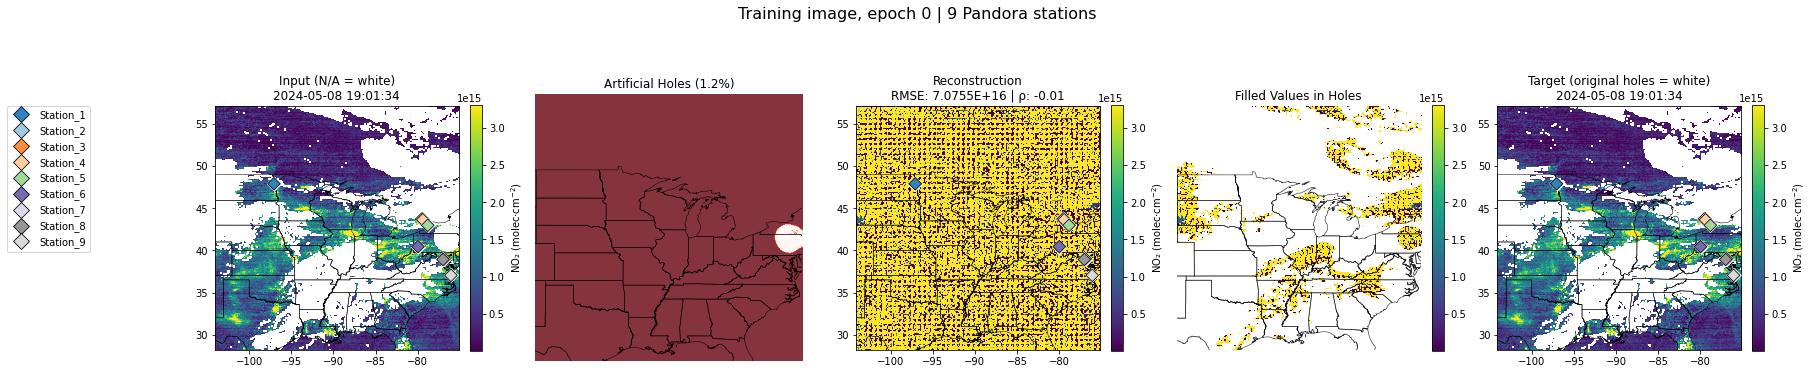

Fill percentage: 100.0%
Pandora RMSE: 8.9931E+16 (9 stations)
Pandora correlation (ρ): -0.518


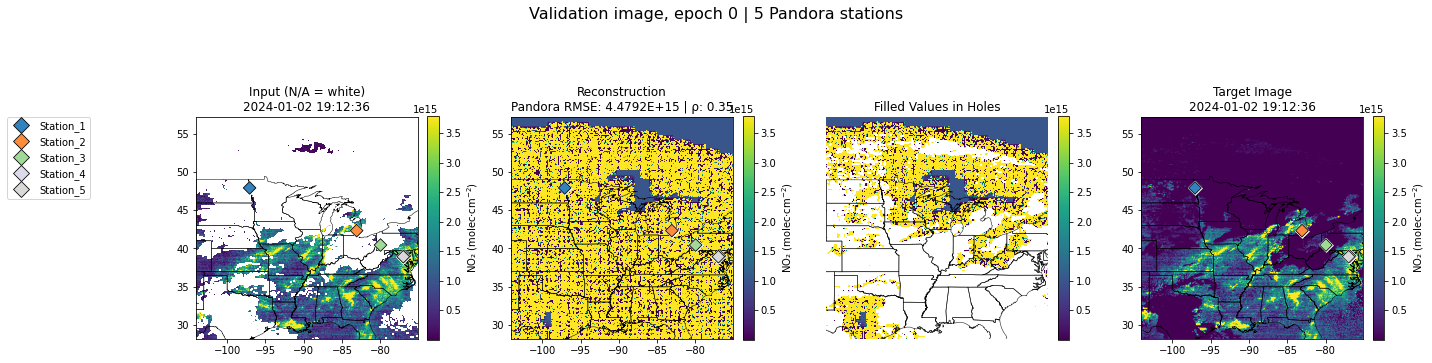

  0%|          | 1/1043 [00:10<2:58:18, 10.27s/it]

Fill percentage: 100.0%
Pandora RMSE: 4.4792E+15 (5 stations)
Pandora correlation (ρ): 0.354


  0%|          | 1/1043 [00:13<3:58:32, 13.74s/it]


KeyboardInterrupt: 

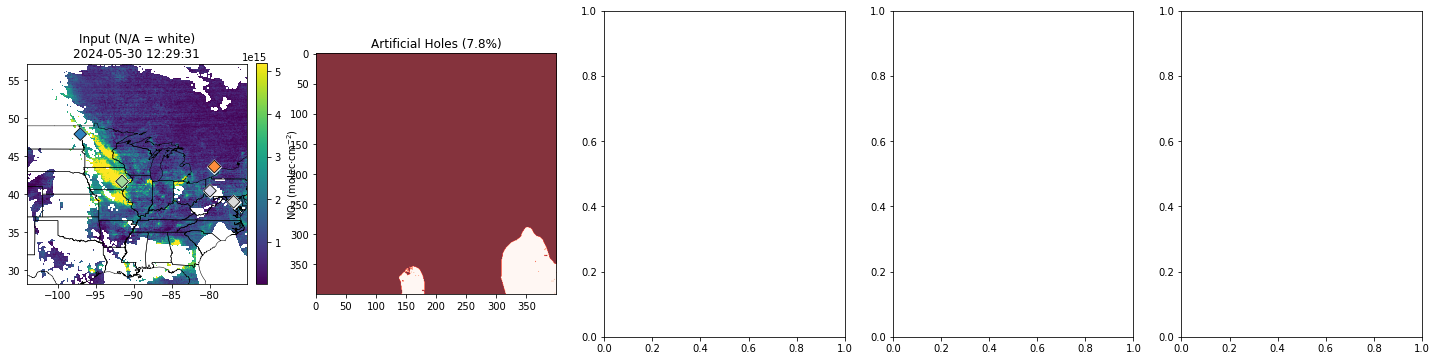

In [167]:
def train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=50, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    
    wait = 0

    history = []
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        train_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}
        batch_count = 0
        
        for batch in tqdm(train_loader):
            img = batch["masked_img"].cuda()          # img with both masks
            mask = batch["known_and_fake_mask"].cuda()      # real missing gaps and artificial gaps
            mask_aug = batch["fake_mask"].cuda()            # 1=kept, 0=artificial hole
            known_mask = batch['known_mask'].cuda()
            target = batch["target"].cuda()
            p_mask = batch.get("p_mask", None)
            p_val_map = batch.get("p_val_mask", None)

            # If Pandora data exists, move to device
            if p_mask is not None:
                p_mask = p_mask.cuda()
                p_val_map = p_val_map.cuda() if p_val_map is not None else None

            pred_t, _ = model(img, mask_aug)
            loss = warmup_loss(pred_t, target, mask_aug)            
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()
            
            # Calculate metrics for fake mask regions
            batch_metrics = calculate_metrics(
                pred_t, target, mask_aug, known_mask, 
                p_mask=p_mask, p_values=p_val_map, normalizer=normalizer)

            for key in batch_metrics:
                if key not in train_metrics:
                    train_metrics[key] = 0.0
                train_metrics[key] += batch_metrics[key]

            batch_count += 1
            for key in train_metrics:
                train_metrics[key] /= batch_count
                
            visualize_batch(epoch, model,normalizer, train_loader, device="cuda",train=True, shp_path=shp_path,save=False)

            visualize_batch(epoch, model, normalizer, val_loader, device="cuda", train=False, shp_path=shp_path,save = False)
        # Average metrics over batches
        train_loss /= len(train_loader)
        for key in train_metrics:
            train_metrics[key] /= batch_count

        # ---- Validation ----
        model.eval()
        val_loss = 0
        batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch["masked_img"].cuda()
                mask = batch["known_mask"].cuda()
                target = batch["target"].cuda()
                p_mask = batch.get("p_mask", None)
                p_val_map = batch.get("p_val_mask", None)

                if p_mask is not None:
                    p_mask = p_mask.cuda()
                    p_val_map = p_val_map.cuda() if p_val_map is not None else None
                    
                pred, _ = model(img, mask)
                loss = warmup_loss(pred, target, mask)
                val_loss += loss.item()
                
                # Calculate metrics for fake mask regions
                batch_metrics = calculate_metrics(
                pred_t, target, mask_aug, known_mask, 
                p_mask=p_mask, p_values=p_val_map, normalizer=normalizer)

                batch_metrics = calculate_metrics(pred, target, mask)
                for key in batch_metrics:
                    val_metrics[key] += batch_metrics[key]
                batch_count += 1
                
        val_loss /= len(val_loader)
       
        visualize_batch(epoch, model, normalizer, val_loader, device="cuda", train=False, shp_path=shp_path,save = False)
        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")   
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")
        
        if train_metrics['n_pandora_stations'] > 0:
            print(f"Train Pandora metrics - RMSE: {train_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {train_metrics['pandora_mae']:.4E}, "
                  f"ρ: {train_metrics['pandora_rho']:.2f}, "
                  f"R²: {train_metrics['pandora_r2']:.2f}")
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), "pconvunet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "pred_min_range": pred.min().item() if 'pred' in locals() else None,
            "pred_max_range": pred.max().item() if 'pred' in locals() else None
        })
        
        with open('csv_history.csv', "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=[
                "epoch", "train_loss", "val_loss", 
                "train_rmse", "train_mae", "train_r2",
                "pred_min_range", "pred_max_range"
            ])
            writer.writeheader()
            writer.writerows(history)
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
model = train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=150, patience=20)

In [ ]:
def train_model(model, normalizer, train_loader, val_loader, shp_path, epochs=50, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    
    wait = 0
    history = []
    
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        train_metrics = {
            'rmse': 0.0, 'mae': 0.0, 'r2': 0.0,
            'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,
            'n_pandora_stations': 0
        }
        train_batch_count = 0
        
        for batch in tqdm(train_loader):
            img = batch["masked_img"].cuda()
            mask = batch["known_and_fake_mask"].cuda()
            mask_aug = batch["fake_mask"].cuda()
            known_mask = batch['known_mask'].cuda()
            target = batch["target"].cuda()
            p_mask = batch.get("p_mask", None)
            p_val_map = batch.get("p_val_mask", None)

            # If Pandora data exists, move to device
            if p_mask is not None:
                p_mask = p_mask.cuda()
                p_val_map = p_val_map.cuda() if p_val_map is not None else None

            pred_t, _ = model(img, mask_aug)
            loss = warmup_loss(pred_t, target, mask_aug)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item()
            
            # Calculate metrics for artificial holes
            batch_metrics = calculate_metrics(
                pred_t, target, mask_aug, known_mask, 
                p_mask=p_mask, p_values=p_val_map, normalizer=normalizer
            )

            for key in batch_metrics:
                if key not in train_metrics:
                    train_metrics[key] = 0.0
                train_metrics[key] += batch_metrics[key]

            train_batch_count += 1

        # Average training metrics over batches
        train_loss /= len(train_loader)
        for key in train_metrics:
            train_metrics[key] /= train_batch_count

        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_metrics = {
            'rmse': 0.0, 'mae': 0.0, 'r2': 0.0,
            'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,
            'n_pandora_stations': 0
        }
        val_batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch["masked_img"].cuda()
                mask = batch["known_mask"].cuda()  # Use known_mask for validation
                target = batch["target"].cuda()
                p_mask = batch.get("p_mask", None)
                p_val_map = batch.get("p_val_mask", None)

                if p_mask is not None:
                    p_mask = p_mask.cuda()
                    p_val_map = p_val_map.cuda() if p_val_map is not None else None
                    
                pred, _ = model(img, mask)
                loss = warmup_loss(pred, target, mask)
                val_loss += loss.item()
                
                # For validation, we can't calculate RMSE/MAE/R² for missing areas since we don't have ground truth
                # But we can calculate Pandora metrics where we have ground truth stations
                batch_metrics = calculate_metrics(
                    pred, target, mask, mask,  # Use mask for both current and known (no artificial holes in val)
                    p_mask=p_mask, p_values=p_val_map, normalizer=normalizer
                )
                
                for key in batch_metrics:
                    if key not in val_metrics:
                        val_metrics[key] = 0.0
                    val_metrics[key] += batch_metrics[key]
                
                val_batch_count += 1
                
        val_loss /= len(val_loader)
        
        # Average validation metrics over batches
        for key in val_metrics:
            val_metrics[key] /= val_batch_count

        # Visualizations (move outside loops for efficiency)
        visualize_batch(epoch, model, normalizer, train_loader, device="cuda", train=True, shp_path=shp_path, save=False)
        visualize_batch(epoch, model, normalizer, val_loader, device="cuda", train=False, shp_path=shp_path, save=False)
        
        # Print metrics
        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        
        # Training metrics
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")
        if train_metrics['n_pandora_stations'] > 0:
            print(f"Train Pandora metrics - RMSE: {train_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {train_metrics['pandora_mae']:.4E}, "
                  f"ρ: {train_metrics['pandora_rho']:.2f}, "
                  f"R²: {train_metrics['pandora_r2']:.2f}")
        
        # Validation metrics (mainly Pandora since we don't have ground truth for missing areas)
        if val_metrics['n_pandora_stations'] > 0:
            print(f"Val Pandora metrics - RMSE: {val_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {val_metrics['pandora_mae']:.4E}, "
                  f"ρ: {val_metrics['pandora_rho']:.2f}, "
                  f"R²: {val_metrics['pandora_r2']:.2f}")
        else:
            print("Val metrics - No Pandora stations available for validation")
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), "pconvunet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        # Store history with all metrics
        history_entry = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "train_pandora_rmse": train_metrics['pandora_rmse'],
            "train_pandora_rho": train_metrics['pandora_rho'],
            "train_n_pandora": train_metrics['n_pandora_stations'],
            "val_pandora_rmse": val_metrics['pandora_rmse'],
            "val_pandora_rho": val_metrics['pandora_rho'],
            "val_n_pandora": val_metrics['n_pandora_stations'],
        }
        
        # Add prediction range if available
        if 'pred' in locals():
            history_entry.update({
                "pred_min_range": pred.min().item(),
                "pred_max_range": pred.max().item()
            })
            
        history.append(history_entry)
        
        # Save to CSV
        with open('csv_history.csv', "w", newline="") as f:
            if history:
                fieldnames = list(history[0].keys())
                writer = csv.DictWriter(f, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(history)
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# Usage
model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
model = train_model(model, normalizer, train_loader, val_loader, shp_path, epochs=150, patience=20)

 48%|████▊     | 504/1043 [07:51<07:30,  1.20it/s]